In [1]:
%cd /data/gunsbrother/repos/vq2d-lightning
%load_ext autoreload
%autoreload 2

/data/gunsbrother/repos/vq2d-lightning


/home/gunsbrother/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from IPython.display import Image as IPImage

from ltvu.lit.model import LitModule
from ltvu.lit.data import LitVQ2DDataModule

import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from diffusers.utils import make_image_grid

import torch
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO


def ten2pil(tensor, pad: float = 0.02, alpha = None, cmap = 'viridis'):
    assert tensor.dim() in (2, 3)  # (H, W), (C, H, W)
    tensor = tensor.cpu()
    tensor -= tensor.min()
    tensor /= tensor.max()

    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
        assert tensor.shape[-1] == 3

    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [pad, pad, 1. - 2* pad, 1. - 2 * pad])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(tensor, aspect='equal', alpha=alpha, cmap=cmap)

    plots_io = BytesIO()
    fig.savefig(plots_io, format='jpg' if alpha is None else 'png', bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(plots_io)
    # plots_io.close()
    return img

GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='config', job_name='asdasdasdasdasd')

/tmp/ipykernel_3250689/2258718274.py:51: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='config', job_name='asdasdasdasdasd')


hydra.initialize()

In [161]:
path_ckpt = 'outputs/batch/2024-09-15/123741/epoch=61-prob_acc=0.7739.ckpt'
plm_base = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm_base.eval()
plm_base.freeze()

# path_ckpt = 'outputs/batch/2024-10-19/133186/epoch=54-prob_acc=0.7952.ckpt'
# path_ckpt = 'outputs/batch/2024-10-21/133643/epoch=22-prob_acc=0.7899.ckpt'
path_ckpt = 'outputs/batch/2024-10-18/132949/epoch=43-prob_acc=0.7532.ckpt'  # loss 없는 거
plm = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm.eval()
plm.freeze()

eval_config = hydra.compose(config_name='eval', overrides=[
    f'ckpt={path_ckpt.replace('=', '\\=')}',
    f'batch_size=1',
    f'num_workers=4',
    f'prefetch_factor=1'
])
pdm = LitVQ2DDataModule(eval_config)  # won't use trainer here nor batched forward pass so no need to load the eval config and plm.config is enough
pdm.batch_size = 1

dict_keys(['segment', 'query', 'gt_bboxes', 'gt_probs', 'before_query_mask', 'video_uid', 'clip_uid', 'annotation_uid', 'seg_idxs', 'query_set', 'clip_fps', 'query_frame', 'visual_crop', 'object_title'])


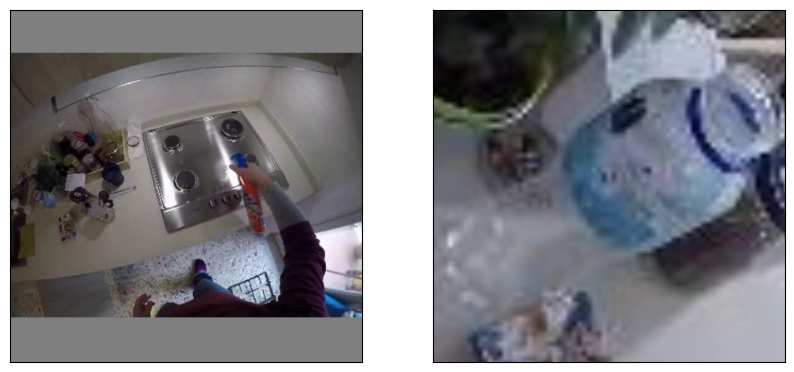

In [162]:
# get
# bidx = 300  # mean iou: 0 vs. 0.450
# bidx = 1307  # mean iou:
# bidx = 2300
bidx = 2305

batch = pdm.get_val_sample(idx=bidx)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.cuda()

# viz
print(batch.keys())
seg = rearrange(batch['segment'][0], 't c h w -> t h w c').cpu().numpy()
q = rearrange(batch['query'][0], 'c h w -> h w c').cpu().numpy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.imshow(seg[len(seg) // 2])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax = axes[1]
ax.imshow(q)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [163]:
with torch.inference_mode():
    inputs = dict(**batch)
    inputs['segment'], inputs['query'] = pdm.normalize(inputs['segment'], inputs['query'])
    # output_dict = plm_base.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)
    output_dict = plm.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)
output_dict.keys()

dict_keys(['feat', 'loss', 'log_dict', 'info_dict', 'pred_dict'])

In [164]:
print(batch['segment'].shape)
print(batch['query'].shape)
print()
t, c, h, w = output_dict['feat']['clip']['backbone'].shape
print(output_dict['feat']['clip']['backbone'].shape)
print(output_dict['feat']['query']['backbone'].shape)
reduce_key = 'late_reduce' if 'late_reduce' in output_dict['feat']['clip'] else 'reduce'
print(output_dict['feat']['clip'][reduce_key].shape)
print(output_dict['feat']['query'][reduce_key].shape)
print(output_dict['feat']['clip']['stx'].shape)
if 'conv' in output_dict['feat']['clip']:
    print(output_dict['feat']['clip']['conv'].shape)
print()
print(f"mean IoU:      {output_dict['log_dict']['iou'].item():.3f}")
print(f"mean prob acc: {output_dict['log_dict']['prob_acc'].item():.3f}")

torch.Size([1, 32, 3, 448, 448])
torch.Size([1, 3, 448, 448])

torch.Size([32, 768, 32, 32])
torch.Size([1, 768, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([32, 256, 32, 32])

mean IoU:      0.394
mean prob acc: 0.656


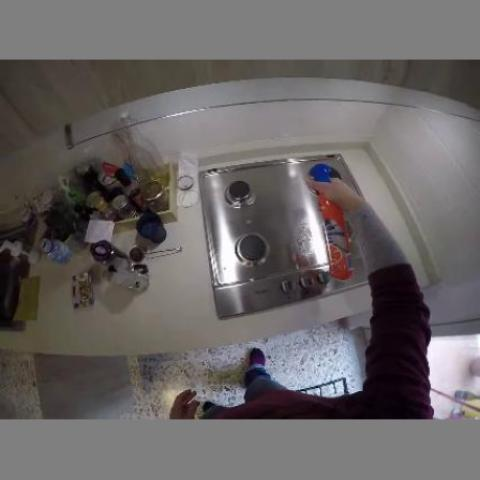

backbone
torch.Size([32768, 4]) torch.Size([4]) torch.Size([768, 4])
tensor([3263.2944, 2115.3794, 1772.6820, 1534.1761], device='cuda:0')


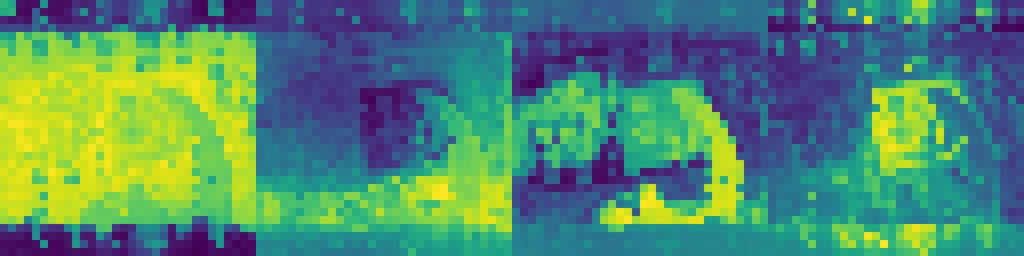

reduce
torch.Size([32768, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([692.3016, 551.4286, 365.6147, 345.2856], device='cuda:0')


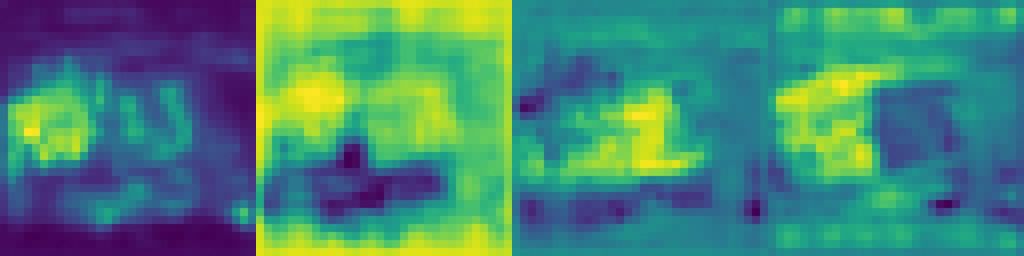

stx
torch.Size([32768, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([260.7971, 210.8618, 175.6839, 128.6437], device='cuda:0')


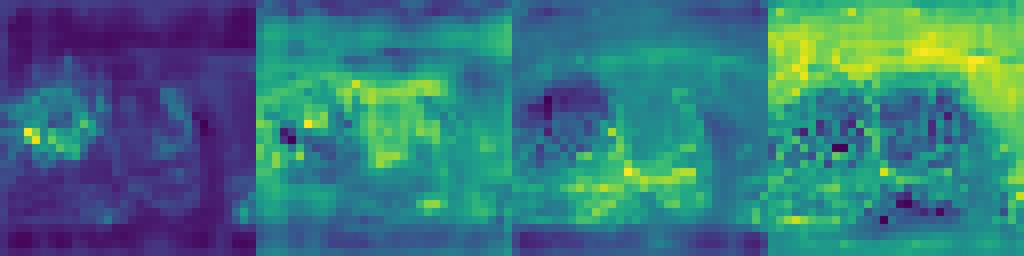

In [157]:
def feats2score(feats, q=4):
    torch.manual_seed(42)
    feat = rearrange(feats, 't c h w -> (t h w) c')
    U, S, V = torch.pca_lowrank(feat, q=q)
    print(U.shape, S.shape, V.shape)
    print(S)
    _feat = feat - feat.mean(dim=0)
    score_map = rearrange(_feat @ V, '(t h w) q -> t q h w', t=t, h=h, w=w)
    return score_map

def gauss(score_map):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / 1000)
    return score_map

Q = 4
_, fidxs = torch.where(batch['gt_probs'] > 1e-3)
fidx = fidxs[len(fidxs) // 2 + 1].item()
display(ten2pil(batch['segment'][0, fidx]))

print('backbone')
score_map = feats2score(output_dict['feat']['clip']['backbone'], q=Q)
images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

if reduce_key == 'reduce':
    print('reduce')
    score_map = feats2score(output_dict['feat']['clip'][reduce_key], q=Q)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))

print('stx')
score_map = feats2score(output_dict['feat']['clip']['stx'], q=Q)
images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

if reduce_key == 'late_reduce':
    print('late_reduce')
    score_map = feats2score(output_dict['feat']['clip'][reduce_key], q=Q)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))

if 'conv' in output_dict['feat']['clip']:
    print('conv')
    score_map = feats2score(output_dict['feat']['clip']['conv'], q=Q)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))

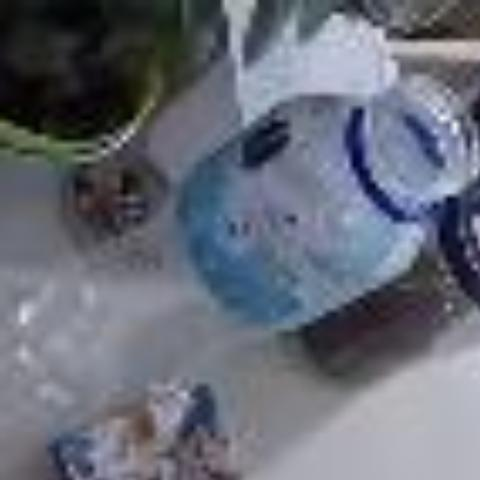

torch.Size([1024, 5]) torch.Size([5]) torch.Size([768, 5])
tensor([511.3435, 406.6245, 340.5271, 253.8861, 235.1728], device='cuda:0')


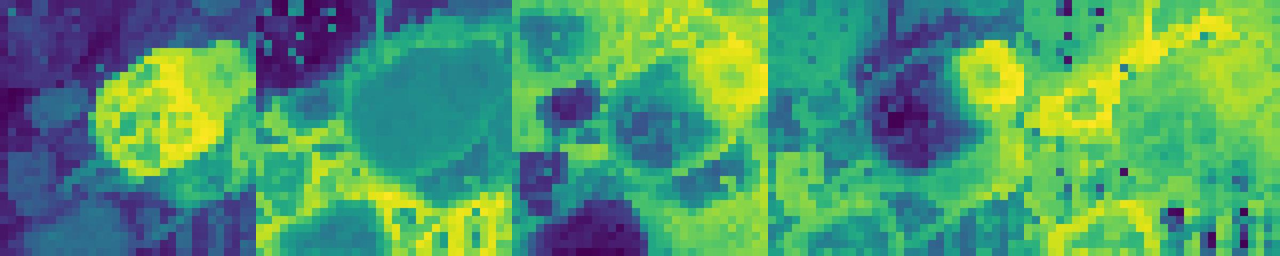

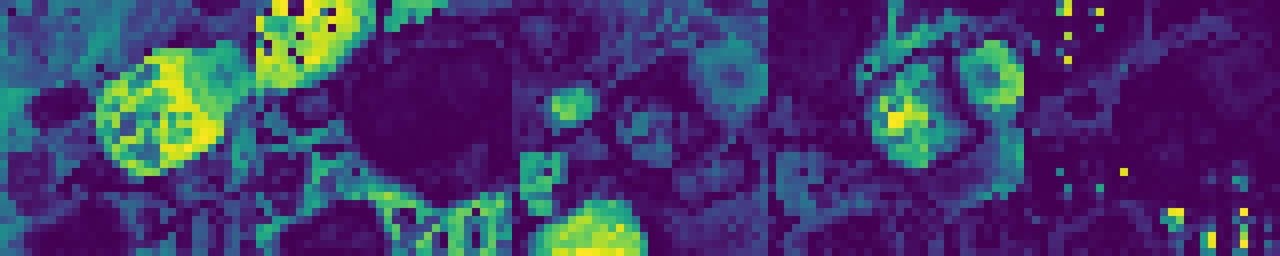

tensor([[[    0.1605,     0.1773,     0.2903,     0.2844,     0.0979,  ...,     0.0228,     0.0222,     0.0244,     0.1482,     0.1414],
         [    0.1837,     0.0013,     0.2211,     0.2463,     0.0970,  ...,     0.0290,     0.0612,     0.1333,     0.1135,     0.0917],
         [    0.2998,     0.1168,     0.0962,     0.0935,     0.1171,  ...,     0.1424,     0.1441,     0.1335,     0.1092,     0.0733],
         [    0.2722,     0.1017,     0.0956,     0.0771,     0.1098,  ...,     0.1744,     0.1260,     0.0946,     0.1077,     0.1039],
         [    0.2177,     0.1675,     0.1448,     0.1079,     0.1219,  ...,     0.0523,     0.0787,     0.0953,     0.1002,     0.0014],
         ...,
         [    0.1716,     0.2073,     0.2853,     0.2097,     0.1191,  ...,     0.0591,     0.0367,     0.1276,     0.0529,     0.0499],
         [    0.3118,     0.2870,     0.2645,     0.1552,     0.0687,  ...,     0.0079,     0.1234,     0.1819,     0.0360,     0.0985],
         [    0.3107,     0

torch.Size([1024, 5]) torch.Size([5]) torch.Size([256, 5])
tensor([111.1434,  86.3924,  79.8059,  64.0494,  55.7921], device='cuda:0')


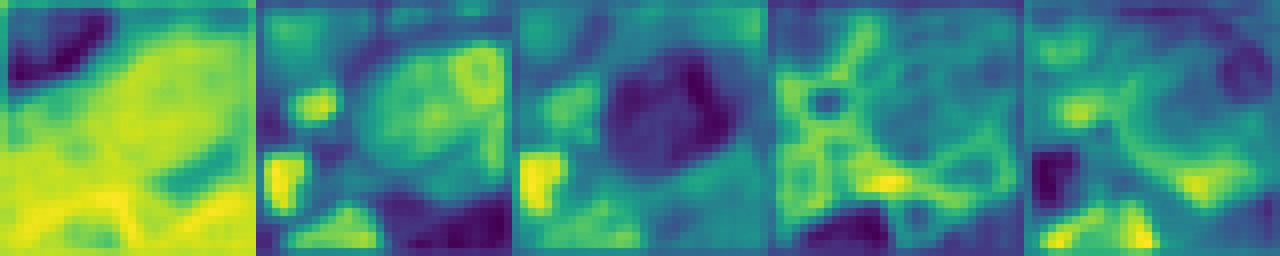

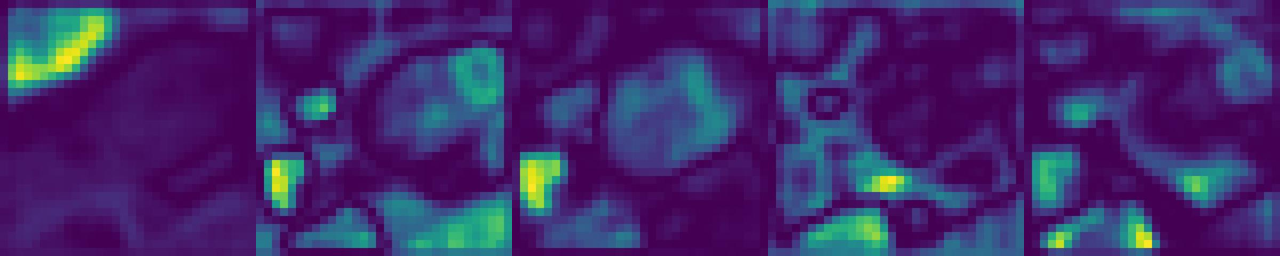

In [165]:
def feat2pcscore(feat, q=4):
    torch.manual_seed(42)
    feat = rearrange(feat, 'c h w -> (h w) c')
    U, S, V = torch.pca_lowrank(feat, q=q)
    print(U.shape, S.shape, V.shape)
    print(S)
    _feat = feat - feat.mean(dim=0)
    score_map = rearrange(_feat @ V, '(h w) q -> q h w', h=h, w=w)
    return score_map

def gauss(score_map):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / 1000)
    return score_map

display(ten2pil(batch['query'][0]))

Q = 5

score_map = feat2pcscore(output_dict['feat']['query']['backbone'][0], q=Q)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
torch.set_printoptions(precision=4, sci_mode=False, threshold=5, edgeitems=5, linewidth=1000)

display(score_map)

score_map = feat2pcscore(output_dict['feat']['query'][reduce_key][0], q=Q)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

In [159]:
output_dict['info_dict']['preds_top']['prob'].sigmoid()

tensor([[0.3324, 0.3199, 0.2779, 0.3136, 0.2944,  ..., 0.4294, 0.3999, 0.3697, 0.3788, 0.3266]], device='cuda:0')

torch.Size([32768, 5]) torch.Size([5]) torch.Size([256, 5])
tensor([260.8234, 210.7192, 175.3112, 138.5821, 130.2435], device='cuda:0')
99 196 163 238


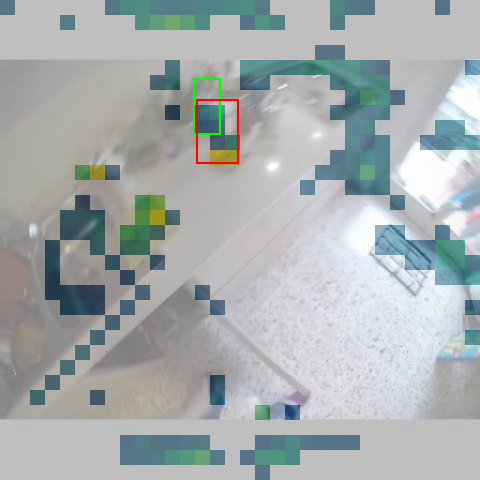

In [160]:
from PIL import ImageDraw

fidx = fidxs[0].item()
qidx = 1

score_map = feats2score(output_dict['feat']['clip']['stx'], q=Q)
score_map = gauss(score_map)
s = score_map[fidx, qidx]
s -= s.min()
s /= s.max()

image1 = ten2pil(batch['segment'][0, fidx]).convert('RGBA')
s_np = s.cpu().numpy()
image2 = ten2pil(s, alpha=(s_np > 0.3).astype(np.uint8))

image = Image.blend(image1, image2, alpha=0.5)
image.putalpha(255)


draw = ImageDraw.Draw(image)

y1, x1, y2, x2 = (batch['gt_bboxes'][0, fidx] * image.size[0]).cpu().numpy().astype(int)
draw.rectangle([(x1, y1), (x2, y2)], outline=(0, 255, 0), width=2)

# x1, y1, x2, y2 = (image.size[0] * output_dict['info_dict']['preds_top']['bbox'][0, fidx]).cpu().numpy().astype(int)
y1, x1, y2, x2 = (image.size[0] * output_dict['info_dict']['preds_top']['bbox'][0, fidx]).cpu().numpy().astype(int)
print(y1, x1, y2, x2)
draw.rectangle([(x1, y1), (x2, y2)], outline=(255, 0, 0), width=2)

image